In [96]:
from tqdm import tqdm
import math
import os
import numpy as np
import pandas as pd
import torch
import gpytorch
import matplotlib.pyplot as plt

#### Starting with just call data

In [155]:
calls = pd.read_csv("SPY_calls.csv")
calls['T'] = calls['T'].astype(np.float32)
calls['mny'] = calls['moneyness'].astype(np.float32)
calls['iv'] = calls['implied_volatility'].astype(np.float32)

calls['st_T'] = (calls['T'] - calls['T'].mean())/calls['T'].std()
calls['st_mny'] = (calls['mny'] - calls['mny'].mean())/calls['mny'].std()
calls['st_iv'] = (calls['iv'] - calls['iv'].mean())/calls['iv'].std()

In [156]:
x = torch.tensor(calls[['st_T', 'st_mny']].values)
y = torch.tensor(calls[['st_iv']].values)
print(x[:5])
print(y[:5])

tensor([[-0.7641, -2.8482],
        [-0.7641, -1.7896],
        [-0.7641, -1.4838],
        [-0.7641, -1.4367],
        [-0.7641, -1.3191]])
tensor([[10.4099],
        [ 3.1303],
        [ 1.8818],
        [ 1.7439],
        [ 1.7629]])


In [157]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)

In [158]:
train_y = train_y.reshape((len(train_y)))
test_y = test_y.reshape((len(test_y)))

####  GP Regression

In [179]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [180]:
# this is for running the notebook in our testing framewor
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

losses = []

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    #print(len(loss))
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    losses.append(loss.item())
    optimizer.step()

Iter 1/50 - Loss: 0.809   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.793   lengthscale: 0.668   noise: 0.669
Iter 3/50 - Loss: 0.775   lengthscale: 0.644   noise: 0.644
Iter 4/50 - Loss: 0.758   lengthscale: 0.621   noise: 0.621
Iter 5/50 - Loss: 0.741   lengthscale: 0.598   noise: 0.598
Iter 6/50 - Loss: 0.725   lengthscale: 0.576   noise: 0.576
Iter 7/50 - Loss: 0.707   lengthscale: 0.554   noise: 0.554
Iter 8/50 - Loss: 0.689   lengthscale: 0.533   noise: 0.533
Iter 9/50 - Loss: 0.670   lengthscale: 0.512   noise: 0.513
Iter 10/50 - Loss: 0.650   lengthscale: 0.492   noise: 0.493
Iter 11/50 - Loss: 0.635   lengthscale: 0.472   noise: 0.474
Iter 12/50 - Loss: 0.612   lengthscale: 0.453   noise: 0.455
Iter 13/50 - Loss: 0.591   lengthscale: 0.434   noise: 0.437
Iter 14/50 - Loss: 0.571   lengthscale: 0.416   noise: 0.419
Iter 15/50 - Loss: 0.550   lengthscale: 0.398   noise: 0.402
Iter 16/50 - Loss: 0.529   lengthscale: 0.380   noise: 0.385
Iter 17/50 - Loss: 0.510   length

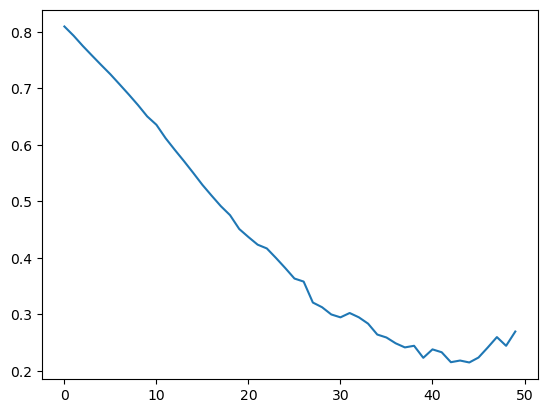

In [181]:
plt.plot(range(len(losses)), losses)
plt.show()

In [182]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    
torch.sqrt(torch.mean(torch.pow(observed_pred.mean - test_y, 2)))

tensor(0.2583)

#### Testing full moneyness spectrum on custom time to expriation

In [186]:
mny = np.array(np.linspace(-1, 1, 100)).astype(np.float32)
t = np.array([0]*100).astype(np.float32)
#mny = 

sample = torch.tensor([t, mny]).T#.reshape((1000, 2))
print(sample[:5])

tensor([[ 0.0000, -1.0000],
        [ 0.0000, -0.9798],
        [ 0.0000, -0.9596],
        [ 0.0000, -0.9394],
        [ 0.0000, -0.9192]])


In [187]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(sample))

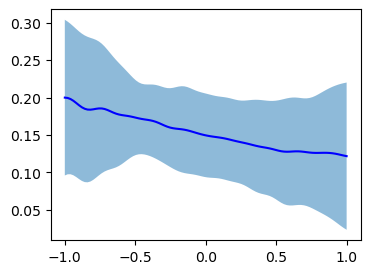

In [188]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    #ax.plot(train_x[:, 1].numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    
    # undo scaling
    lower = lower.numpy() * calls['iv'].std() + calls['iv'].mean()
    upper = upper.numpy() * calls['iv'].std() + calls['iv'].mean()
    preds = observed_pred.mean.numpy() * calls['iv'].std() + calls['iv'].mean()
    
    
    
    #ax.plot(mny, observed_pred.mean.numpy(), 'b')
    ax.plot(mny, preds, 'b')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(mny, lower.numpy(), upper.numpy(), alpha=0.5)
    ax.fill_between(mny, lower, upper, alpha=0.5)
    #ax.set_ylim([-3, 3])
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])